# Locomotion Analysis

In [44]:

all_datasets = {
    
        # Datasets for 09-30
        "DAL01_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\2024_09_30-09_51_52\Smooth15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
        "DAL02_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\2024_09_30-10_33_45\Smooth15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
        "DAL03_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\2024_09_30-11_13_52\Smooth15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
        "DAL04_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\2024_09_30-11_59_31\Smooth15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv"),
        # Datasets for 09-20
        "DAL01_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\2024_09_20-09_44_21\Smoothed_15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
        "DAL02_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\2024_09_20-10_23_56\Smoothed_15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
        "DAL03_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\2024_09_20-11_00_21\Smoothed_15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
        "DAL04_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\2024_09_20-11_36_06\Smoothed_15\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv")
    }



# Group datasets by mouse and process each mouse's three datasets separately
grouped_datasets = {
    "DAL01": ["DAL01_0930", "DAL01_0920"],
    "DAL02": ["DAL02_0930", "DAL02_0920"],
    "DAL03": ["DAL03_0930", "DAL03_0920"],
    "DAL04": ["DAL04_0930", "DAL04_0920"]
}

# Aggregate data per mouse
mouse_averages = {
    "DAL01": {"onsets": [], "offsets": []},
    "DAL02": {"onsets": [], "offsets": []},
    "DAL03": {"onsets": [], "offsets": []},
    "DAL04": {"onsets": [], "offsets": []}
}

# Define mapping of channels to regions (CS vs DLS)
channel_mapping = {
    "DAL01": ("CS", "DLS"),
    "DAL02": ("DLS", "CS"),
    "DAL03": ("CS", "DLS"),
    "DAL04": ("DLS", "CS")
}


In [1]:
# ============================================================
# Raw traces per session (first half) + Zoom window with bouts
# - Zoom window set by timestamps (ZOOM_START_SEC/ZOOM_END_SEC)
# - Photometry smoothing level param: 5, 10, or 15 (Smooth*/Smoothed_* auto)
# - Velocity in mm/s -> cm/s (÷10), Howe-style 50 ms MA BEFORE acceleration
# - Dombeck mask (|v|>V_THRESH, |acc|>A_THRESH within ±WIN_SEC), drop bouts < MIN_BOUT_SEC
# - Photometry highlighting: translucent bout shading (no thicker lines), same color as speed/accel shading
# - Markers: START = green ▲, STOP = red ▼ on ALL panels
# - Saves PDFs to C:\Users\KianCaplan\Downloads\Raw-Traces
# ============================================================

import os, glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from numpy.lib.stride_tricks import sliding_window_view

# ---------------------- USER PARAMETERS ----------------------
EXPORT_BASE = r"C:\Users\KianCaplan\Downloads"
EXPORT_DIR  = os.path.join(EXPORT_BASE, "Raw-Traces")  # output folder
PHOT_SMOOTH_LEVEL = 5          # choose: 5, 10, or 15
ZOOM_START_SEC = 550.0          # zoom window start (s)
ZOOM_END_SEC   = 600.0          # zoom window end (s)

# Movement (Dombeck/Azcorra) thresholds
V_THRESH     = 5              # cm/s
A_THRESH     = 50.0             # cm/s^2
WIN_SEC      = 1             # ± window to test thresholds
MIN_BOUT_SEC = 0.5             # remove bouts shorter than this

# Assumed photometry-aligned rate (used for mask/time alignment)
FS_PHOT = 25.0

# ---------------------- PLOT STYLE ---------------------------
os.makedirs(EXPORT_DIR, exist_ok=True)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

CS_COLOR    = "#0b3d91"    # blue
DLS_COLOR   = "#2ca02c"    # green
BOUT_SHADE  = "#ffcc88"    # light orange (used on ALL panels)
START_COLOR = "green"      # ▲ start
STOP_COLOR  = "red"        # ▼ stop

# ---------------------- DATASET PATHS ------------------------
# Store the run directory (parent of Smooth*/Smoothed_*), and the locomotion CSV path.
all_datasets = {
    # 09-30 (Smooth5 in your tree)
    "DAL01_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\2024_09_30-09_51_52",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
    "DAL02_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\2024_09_30-10_33_45",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
    "DAL03_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\2024_09_30-11_13_52",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
    "DAL04_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\2024_09_30-11_59_31",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv"),
    # 09-20 (Smoothed_5 in your tree)
    "DAL01_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\2024_09_20-09_44_21",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
    "DAL02_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\2024_09_20-10_23_56",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
    "DAL03_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\2024_09_20-11_00_21",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
    "DAL04_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\2024_09_20-11_36_06",
                   r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv"),
}

# Channel-to-region mapping
channel_mapping = {
    "DAL01": ("CS", "DLS"),
    "DAL02": ("DLS", "CS"),
    "DAL03": ("CS", "DLS"),
    "DAL04": ("DLS", "CS"),
}

# ---------------------- HELPERS ------------------------------
def resolve_fluo_csv(run_dir, smooth_level=5):
    """
    Find Fluorescence_470_Z-score.csv under either 'Smooth{n}' or 'Smoothed_{n}'.
    """
    n = int(smooth_level)
    candidates = [
        os.path.join(run_dir, f"Smooth{n}", "Fluorescence_470_Z-score.csv"),
        os.path.join(run_dir, f"Smoothed_{n}", "Fluorescence_470_Z-score.csv"),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    # fallback: search by glob
    hits = glob.glob(os.path.join(run_dir, f"*{n}*", "Fluorescence_470_Z-score.csv"))
    if hits:
        return hits[0]
    raise FileNotFoundError(
        f"Could not find Fluorescence_470_Z-score.csv for level {n} under {run_dir}. "
        f"Tried: {candidates}"
    )

def howe_smooth_and_accel_cmps(t_loco, vel_mm_s):
    """
    Convert velocity mm/s -> cm/s; 50 ms moving-average at native loco rate; forward-diff accel.
    Returns speed_cm_s, accel_cm_s2, fs_loco, t_loco_seconds.
    """
    # timestamps -> seconds, start at 0
    t_loco = np.asarray(t_loco, float)
    if np.nanmax(t_loco) > 1e5:
        t_loco = t_loco / 1000.0
    t_loco = t_loco - t_loco[0]

    vel_cm_s = np.asarray(vel_mm_s, float) / 10.0
    fs_loco = 1.0 / np.median(np.diff(t_loco))
    win = max(1, int(round(0.050 * fs_loco)))  # 50 ms
    if win % 2 == 0:
        win += 1
    kernel = np.ones(win, dtype=float) / win

    speed_cm = np.convolve(np.abs(vel_cm_s), kernel, mode='same')
    accel_cm2 = np.r_[np.diff(speed_cm) * fs_loco, 0.0]  # pad
    return speed_cm, accel_cm2, fs_loco, t_loco

def build_movement_mask_dombeck(speed, accel, fs, v_thresh, a_thresh, win_sec):
    """
    Mark sample t as 'movement' if within ±win_sec there exists
    (speed > v_thresh AND |accel| > a_thresh).
    """
    N = len(speed); w = int(round(win_sec * fs))
    mask = np.zeros(N, dtype=bool)
    if N < 2*w + 1:
        return mask
    S = sliding_window_view(speed, 2*w + 1)  # (N-2w, 2w+1)
    A = sliding_window_view(accel, 2*w + 1)
    mid = (S.max(axis=1) > v_thresh) & (np.abs(A).max(axis=1) > a_thresh)
    mask[w:N-w] = mid
    return mask

def prune_short_bouts(mask, fs, min_bout_sec):
    if not min_bout_sec or min_bout_sec <= 0:
        return mask
    m = mask.copy()
    min_len = int(round(min_bout_sec * fs))
    diff = np.diff(m.astype(int), prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    for s, e in zip(starts, ends):
        if (e - s) < min_len:
            m[s:e] = False
    return m

# ---------------------- MAIN LOOP ----------------------------
for dataset_id, (run_dir, loco_csv) in all_datasets.items():
    # Photometry (SmoothN/Smoothed_N -> Fluorescence_470_Z-score.csv)
    fluo_csv = resolve_fluo_csv(run_dir, smooth_level=PHOT_SMOOTH_LEVEL)
    fdf = pd.read_csv(fluo_csv)
    t_f  = fdf.iloc[:, 0].astype(float).to_numpy() / 1000.0
    ch1z = fdf.iloc[:, 1].astype(float).to_numpy()
    ch2z = fdf.iloc[:, 2].astype(float).to_numpy()

    # Locomotion (timestamp, velocity in mm/s)
    ldf = pd.read_csv(loco_csv, skiprows=1)
    t_l  = ldf.iloc[:, 0].astype(float).to_numpy()
    vel  = ldf.iloc[:, 1].astype(float).to_numpy()

    # Howe-style speed/accel at loco rate (cm/s, cm/s^2), then interpolate to FP grid
    speed_cm, accel_cm2, fs_loco, t_l = howe_smooth_and_accel_cmps(t_l, vel)
    keep = t_l <= t_f[-1]
    t_lc = t_l[keep]; sp_c = speed_cm[keep]; ac_c = accel_cm2[keep]
    speed_fp = np.interp(t_f, t_lc, sp_c)   # cm/s on FP grid
    accel_fp = np.interp(t_f, t_lc, ac_c)   # cm/s^2 on FP grid

    # Small smoothing post-resample to reduce jitter (~40 ms @25 Hz)
    speed_fp = gaussian_filter1d(speed_fp, sigma=1)
    accel_fp = gaussian_filter1d(accel_fp, sigma=1)

    # Map channels to CS/DLS colors
    mouse_id = dataset_id.split('_')[0]
    ch1_label, ch2_label = channel_mapping[mouse_id]
    if ch1_label == "CS":
        cs_trace, dls_trace = ch1z, ch2z
    else:
        cs_trace, dls_trace = ch2z, ch1z

    # Movement mask on FP grid
    move_mask = build_movement_mask_dombeck(speed_fp, accel_fp, fs=FS_PHOT,
                                            v_thresh=V_THRESH, a_thresh=A_THRESH, win_sec=WIN_SEC)
    move_mask = prune_short_bouts(move_mask, fs=FS_PHOT, min_bout_sec=MIN_BOUT_SEC)

    # Time aligned to 0
    t_aligned = t_f - t_f[0]

    # ===================== First half plot =====================
    half = len(t_f) // 2
    t    = t_aligned[:half]
    cs   = cs_trace[:half]
    dls  = dls_trace[:half]
    sp   = speed_fp[:half]
    ac   = accel_fp[:half]
    mask_half = move_mask[:half]

    fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True,
                             gridspec_kw=dict(hspace=0.15))
    axes[0].plot(t, cs,  color=CS_COLOR,  lw=1); axes[0].set_ylabel("CS (Z)")
    axes[0].set_title(f"{dataset_id} — First Half (smoothing={PHOT_SMOOTH_LEVEL})")
    axes[1].plot(t, dls, color=DLS_COLOR, lw=1); axes[1].set_ylabel("DLS (Z)")
    axes[2].plot(t, sp,  color="0.1", lw=1);     axes[2].set_ylabel("Speed (cm/s)")
    axes[3].plot(t, ac,  color="0.2", lw=1);     axes[3].set_ylabel("Accel (cm/s²)")
    axes[3].set_xlabel("Time (s)")

    # --- translucent movement shading on ALL panels (incl. fluorescence) ---
    diff_half = np.diff(mask_half.astype(int), prepend=0, append=0)
    starts_h = np.where(diff_half == 1)[0]
    ends_h   = np.where(diff_half == -1)[0]
    if len(ends_h) and len(starts_h) and ends_h[0] < starts_h[0]:
        ends_h = ends_h[1:]
    if len(starts_h) > len(ends_h):
        starts_h = starts_h[:len(ends_h)]
    for s_idx, e_idx in zip(starts_h, ends_h):
        if e_idx > s_idx:
            x0 = t[s_idx]
            x1 = t[min(max(e_idx-1, 0), len(t)-1)]
            for ax in axes:  # shade CS, DLS, Speed, Accel (same color)
                ax.axvspan(x0, x1, color=BOUT_SHADE, alpha=0.25, lw=0)

    # start/stop markers on all panels
    start_times = t[starts_h] if len(starts_h) else np.array([])
    end_times   = t[np.clip(ends_h - 1, 0, len(t)-1)] if len(ends_h) else np.array([])
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        y_top = ymax - 0.03*(ymax - ymin)
        if start_times.size:
            ax.plot(start_times, np.full_like(start_times, y_top, dtype=float),
                    '^', color=START_COLOR, markeredgecolor='k', markeredgewidth=0.5,
                    markersize=6, linestyle='None', zorder=6, label='_nolegend_')
        if end_times.size:
            ax.plot(end_times, np.full_like(end_times, y_top, dtype=float),
                    'v', color=STOP_COLOR, markeredgecolor='k', markeredgewidth=0.5,
                    markersize=6, linestyle='None', zorder=6, label='_nolegend_')
        ax.axhline(0, color='k', lw=0.5, alpha=0.3)

    out1 = os.path.join(EXPORT_DIR, f"raw_firsthalf_{dataset_id}_smooth{PHOT_SMOOTH_LEVEL}.pdf")
    fig.savefig(out1, format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)
    plt.close(fig)

    # ===================== Zoom window with bout markers =====================
    t0, t1 = float(ZOOM_START_SEC), float(ZOOM_END_SEC)
    t1 = min(t1, t_aligned[-1])  # cap at recording end
    if t0 >= t1:
        t0, t1 = 0.0, min(200.0, t_aligned[-1])  # safe fallback

    idx_zoom = (t_aligned >= t0) & (t_aligned <= t1)
    tz   = t_aligned[idx_zoom]
    csz  = cs_trace[idx_zoom]
    dlsz = dls_trace[idx_zoom]
    spz  = speed_fp[idx_zoom]
    acz  = accel_fp[idx_zoom]
    maskz = move_mask[idx_zoom]

    fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True,
                             gridspec_kw=dict(hspace=0.15))
    axes[0].plot(tz, csz,  color=CS_COLOR,  lw=1); axes[0].set_ylabel("CS (Z)")
    axes[0].set_title(f"{dataset_id} — Zoom {t0:.0f}–{t1:.0f} s (smooth={PHOT_SMOOTH_LEVEL})")
    axes[1].plot(tz, dlsz, color=DLS_COLOR, lw=1); axes[1].set_ylabel("DLS (Z)")
    axes[2].plot(tz, spz,  color="0.1", lw=1);     axes[2].set_ylabel("Speed (cm/s)")
    axes[3].plot(tz, acz,  color="0.2", lw=1);     axes[3].set_ylabel("Accel (cm/s²)")
    axes[3].set_xlabel("Time (s)")

    # Bout spans (shade ALL panels) + start/stop markers
    diffz = np.diff(maskz.astype(int), prepend=0, append=0)
    starts_z = np.where(diffz == 1)[0]
    ends_z   = np.where(diffz == -1)[0]
    s_for_span, e_for_span = starts_z.copy(), ends_z.copy()
    if len(e_for_span) and len(s_for_span) and e_for_span[0] < s_for_span[0]:
        e_for_span = e_for_span[1:]
    if len(s_for_span) > len(e_for_span):
        s_for_span = s_for_span[:len(e_for_span)]
    for s_idx, e_idx in zip(s_for_span, e_for_span):
        x0 = tz[s_idx]
        x1 = tz[min(max(e_idx-1, 0), len(tz)-1)]
        for ax in axes:  # shade CS, DLS, Speed, Accel
            ax.axvspan(x0, x1, color=BOUT_SHADE, alpha=0.25, lw=0)

    start_times = tz[starts_z] if len(starts_z) else np.array([])
    end_times   = tz[np.clip(ends_z - 1, 0, len(tz)-1)] if len(ends_z) else np.array([])
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        y_top = ymax - 0.03*(ymax - ymin)
        if start_times.size:
            ax.plot(start_times, np.full_like(start_times, y_top, dtype=float),
                    '^', color=START_COLOR, markeredgecolor='k', markeredgewidth=0.5,
                    markersize=6, linestyle='None', zorder=6, label='_nolegend_')
        if end_times.size:
            ax.plot(end_times, np.full_like(end_times, y_top, dtype=float),
                    'v', color=STOP_COLOR, markeredgecolor='k', markeredgewidth=0.5,
                    markersize=6, linestyle='None', zorder=6, label='_nolegend_')
        ax.axhline(0, color='k', lw=0.5, alpha=0.3)

    out2 = os.path.join(EXPORT_DIR, f"raw_zoom_{int(t0)}to{int(t1)}_{dataset_id}_smooth{PHOT_SMOOTH_LEVEL}.pdf")
    fig.savefig(out2, format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)
    plt.close(fig)

print(f"Saved PDFs to: {EXPORT_DIR}")


Saved PDFs to: C:\Users\KianCaplan\Downloads\Raw-Traces


# Locomotion Cross-Correlation

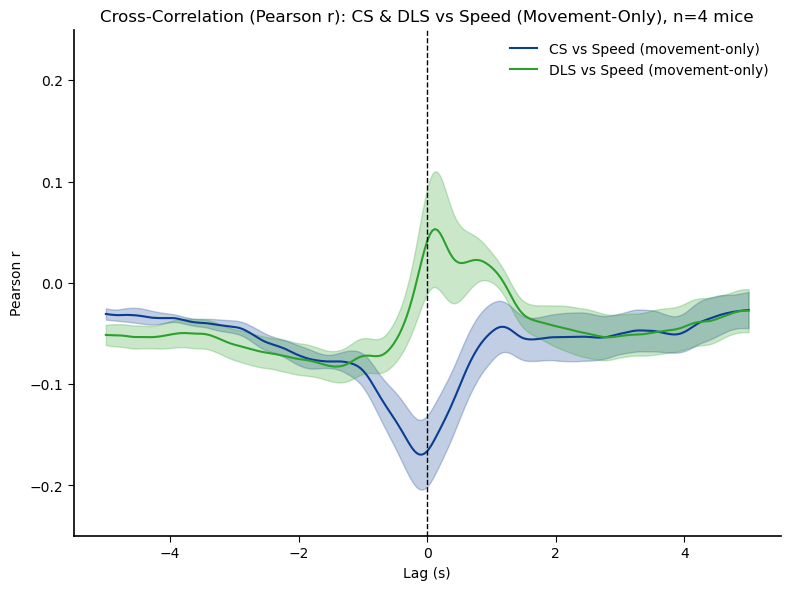

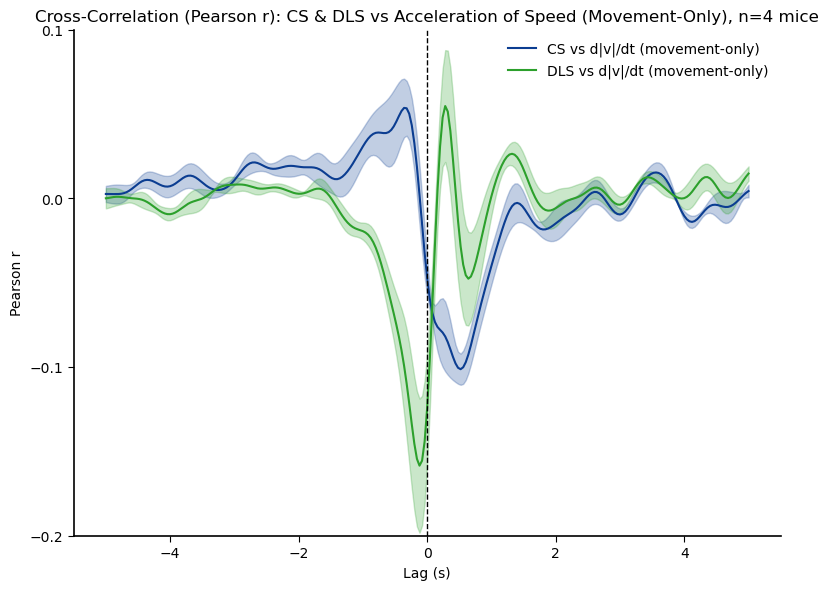

Saved PDFs to: C:\Users\KianCaplan\Downloads
[Summary | Speed] r at τ=0 s — CS: -0.1663 ± 0.0404, DLS: 0.0412 ± 0.0600  (n=4)
[Summary | Accel (−1–0 s)] CS peak: 0.0635 ± 0.0194 (lag -0.500 ± 0.144 s); DLS trough: -0.1614 ± 0.0450 (lag -0.110 ± 0.019 s)  (n=4)
[Summary | Accel (0–1 s)] CS trough: -0.1144 ± 0.0090 (lag 0.440 ± 0.077 s); DLS peak: 0.0662 ± 0.0365 (lag 0.470 ± 0.178 s)  (n=4)


In [6]:
# ============================================================
# Movement-only FP x Speed & Acceleration Cross-Correlation
# (Dombeck thresholds) + EXACTLY TWO 300 dpi PDF exports
# + Fisher z-based paired tests (peak & per-lag FDR)
# + Despined (no boxes) plots
# ============================================================

# ------------------ Imports & export settings ------------------
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import ttest_rel, t  # (unused now; left for reproducibility/parity)

# Export path (Windows)
EXPORT_DIR = r"C:\Users\KianCaplan\Downloads"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Publication-friendly PDF fonts
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

# Colors
CS_COLOR  = "#0b3d91"   # darker blue
DLS_COLOR = "#2ca02c"   # green

# ----------------------- Analysis params -----------------------
FS_PHOT = 25.0              # Hz (photometry-aligned sampling)
MAX_LAG_SEC = 5             # +/- seconds for xcorr
SMOOTH_SIGMA_SAMPLES = 5    # smoothing for speed & post-diff accel (samples @ 25 Hz)

# Dombeck/Azcorra movement criteria (assumes cm/s, cm/s^2)
DOMBECK_V_THRESH = 5        # cm/s
DOMBECK_A_THRESH = 50.0     # cm/s^2
DOMBECK_WIN_SEC  = 1.0      # +/- 1 s window
MIN_BOUT_SEC     = 0.5      # optional cleanup of tiny bouts

# ----------------------- Helpers -----------------------
def normalize_signal(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-12)

def _keep_min_bouts(mask, fs, min_bout_sec):
    if not min_bout_sec or min_bout_sec <= 0:
        return mask
    min_len = int(round(min_bout_sec * fs))
    if min_len <= 1:
        return mask
    m = mask.copy()
    diff = np.diff(m.astype(int), prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    for s, e in zip(starts, ends):
        if (e - s) < min_len:
            m[s:e] = False
    return m

def build_movement_mask_dombeck(speed, accel, fs, v_thresh=DOMBECK_V_THRESH,
                                a_thresh=DOMBECK_A_THRESH, win_sec=DOMBECK_WIN_SEC):
    """
    A sample is 'movement' if, within a ±win_sec window centered on it,
    speed > v_thresh AND |accel| > a_thresh at least once.
    Edges without a full window are set False.
    """
    N = len(speed)
    w = int(round(win_sec * fs))
    mask = np.zeros(N, dtype=bool)
    if N < 2*w + 1:
        return mask
    S = sliding_window_view(speed, 2*w + 1)        # shape: (N-2w, 2w+1)
    A = sliding_window_view(accel, 2*w + 1)
    mid = (S.max(axis=1) > v_thresh) & (np.abs(A).max(axis=1) > a_thresh)
    mask[w:N-w] = mid
    return mask

def calculate_cross_correlation_masked(s1, s2, mask, fs=FS_PHOT, max_lag=MAX_LAG_SEC):
    """
    Movement-only Pearson correlation (r) as a function of lag.

    For each lag k, form pairs (t, t-k) and keep only those where
    mask[t] & mask[t-k] are True. Pearson r is computed over those pairs.
    """
    assert len(s1) == len(s2) == len(mask)
    N = len(s1)
    L = int(round(max_lag * fs))
    lags_samp = np.arange(-L, L + 1, dtype=int)
    lags = lags_samp / fs
    out = np.full(lags_samp.shape, np.nan, dtype=float)

    for i, k in enumerate(lags_samp):
        if k >= 0:
            x = s1[k:]; y = s2[:N-k]; m = mask[k:] & mask[:N-k]
        else:
            kk = -k
            x = s1[:N-kk]; y = s2[kk:]; m = mask[:N-kk] & mask[kk:]
        if m.sum() < 10:
            continue
        xm, ym = x[m], y[m]
        xm = xm - xm.mean()
        ym = ym - ym.mean()
        denom = (xm.std() * ym.std()) + 1e-12
        out[i] = np.mean(xm * ym) / denom
    return out, lags

# ------------------ Per-dataset processing ------------------
def process_and_calculate_correlation(fluorescence_file, locomotion_file):
    # Photometry (ms, ch1, ch2)
    fluo = pd.read_csv(fluorescence_file)
    t_f = fluo.iloc[:, 0].values / 1000.0
    ch1 = fluo.iloc[:, 1].values
    ch2 = fluo.iloc[:, 2].values

    # Locomotion (timestamp, velocity @ 100 Hz)
    loco = pd.read_csv(locomotion_file, skiprows=1)
    vel = loco.iloc[:, 1].values.astype(float)
    t_l = loco.iloc[:, 0].values.astype(float)
    t_l = t_l - t_l[0]

    # Use UNSIGNED speed (keep as-is)
    speed = np.abs(vel)

    # Clip to photometry end & interpolate to photometry timestamps
    keep = t_l <= t_f[-1]
    t_l = t_l[keep]; speed = speed[keep]
    speed_interp = np.interp(t_f, t_l, speed)

    # Speed for correlation (smooth after interpolation)
    speed_sm = gaussian_filter1d(speed_interp, sigma=SMOOTH_SIGMA_SAMPLES)
    z_speed  = normalize_signal(speed_sm)

    # Acceleration of speed: forward difference at 25 Hz, smooth AFTER diff
    acc = np.diff(speed_interp) * FS_PHOT                 # d|v|/dt, length N-1
    acc = gaussian_filter1d(acc, sigma=SMOOTH_SIGMA_SAMPLES)
    z_acc = normalize_signal(acc)

    # Align everything to N-1 (to avoid half-sample shift)
    ch1_trim   = ch1[:-1]
    ch2_trim   = ch2[:-1]
    speed_sm_t = speed_sm[:-1]
    z_speed_t  = z_speed[:-1]

    # Movement mask (Dombeck) on trimmed speed & accel
    move_mask = build_movement_mask_dombeck(speed_sm_t, acc, fs=FS_PHOT)
    move_mask = _keep_min_bouts(move_mask, FS_PHOT, MIN_BOUT_SEC)

    # Movement-only Pearson cross-correlations
    corr_fp1_spd, lags_spd = calculate_cross_correlation_masked(ch1_trim, z_speed_t, move_mask)
    corr_fp2_spd, _        = calculate_cross_correlation_masked(ch2_trim, z_speed_t, move_mask)
    corr_fp1_acc, lags_acc = calculate_cross_correlation_masked(ch1_trim, z_acc,      move_mask)
    corr_fp2_acc, _        = calculate_cross_correlation_masked(ch2_trim, z_acc,      move_mask)

    return corr_fp1_spd, corr_fp2_spd, corr_fp1_acc, corr_fp2_acc, lags_spd, lags_acc

# ------------------ Mapping & dataset paths ------------------
channel_mapping = {
    "DAL01": ("CS", "DLS"),
    "DAL02": ("DLS", "CS"),
    "DAL03": ("CS", "DLS"),
    "DAL04": ("DLS", "CS"),
}

all_datasets = {
        # Datasets for 09-30
        "DAL01_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\2024_09_30-09_51_52\Smooth5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
        "DAL02_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\2024_09_30-10_33_45\Smooth5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
        "DAL03_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\2024_09_30-11_13_52\Smooth5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
        "DAL04_0930": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\2024_09_30-11_59_31\Smooth5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv"),
        # Datasets for 09-20
        "DAL01_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\2024_09_20-09_44_21\Smoothed_5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL01_Ch1Left_Ch2Right\DAL01_LocomotionData.csv"),
        "DAL02_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\2024_09_20-10_23_56\Smoothed_5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL02_Ch1Left_Ch2Right\DAL02_LocomotionData.csv"),
        "DAL03_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\2024_09_20-11_00_21\Smoothed_5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL03_Ch1Left_Ch2Right\DAL03_LocomotionData.csv"),
        "DAL04_0920": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\2024_09_20-11_36_06\Smoothed_5\Fluorescence_470_Z-score.csv",
                       r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240920\DAL04_Ch1Left_Ch2Right\DAL04_LocomotionData.csv")
    }

# ---------------- Collect per-mouse movement-only xcorrs ----------------
all_mouse_corrs_cs_speed = {m: [] for m in channel_mapping}
all_mouse_corrs_dls_speed = {m: [] for m in channel_mapping}
all_mouse_corrs_cs_acc   = {m: [] for m in channel_mapping}
all_mouse_corrs_dls_acc  = {m: [] for m in channel_mapping}

lags_speed_ref = None
lags_acc_ref = None

for dataset_id, (fluorescence_file, locomotion_file) in all_datasets.items():
    mouse_id = dataset_id.split('_')[0]
    c1_spd, c2_spd, c1_acc, c2_acc, lags_spd, lags_acc = process_and_calculate_correlation(
        fluorescence_file, locomotion_file
    )
    lags_speed_ref = lags_spd
    lags_acc_ref   = lags_acc

    ch1_label, ch2_label = channel_mapping[mouse_id]
    if ch1_label == "CS":
        all_mouse_corrs_cs_speed[mouse_id].append(c1_spd)
        all_mouse_corrs_dls_speed[mouse_id].append(c2_spd)
        all_mouse_corrs_cs_acc[mouse_id].append(c1_acc)
        all_mouse_corrs_dls_acc[mouse_id].append(c2_acc)
    else:
        all_mouse_corrs_cs_speed[mouse_id].append(c2_spd)
        all_mouse_corrs_dls_speed[mouse_id].append(c1_spd)
        all_mouse_corrs_cs_acc[mouse_id].append(c2_acc)
        all_mouse_corrs_dls_acc[mouse_id].append(c1_acc)

# --------------- Average per mouse, then group mean/SEM ---------------
def aggregate_mouse_lists(d):
    out = []
    for m in channel_mapping:
        if d[m]:
            out.append(np.nanmean(d[m], axis=0))
    return out

avg_cs_spd  = aggregate_mouse_lists(all_mouse_corrs_cs_speed)
avg_dls_spd = aggregate_mouse_lists(all_mouse_corrs_dls_speed)
avg_cs_acc  = aggregate_mouse_lists(all_mouse_corrs_cs_acc)
avg_dls_acc = aggregate_mouse_lists(all_mouse_corrs_dls_acc)

if not avg_cs_spd or not avg_dls_spd:
    raise ValueError("No speed data aggregated — check dataset paths and mapping.")
if not avg_cs_acc or not avg_dls_acc:
    print("Warning: no acceleration data aggregated (all-NaN or empty).")

# Equalize lengths
min_len_spd = min(len(c) for c in (avg_cs_spd + avg_dls_spd))
avg_cs_spd  = [c[:min_len_spd] for c in avg_cs_spd]
avg_dls_spd = [c[:min_len_spd] for c in avg_dls_spd]
lags_speed  = lags_speed_ref[:min_len_spd]

min_len_acc = min(len(c) for c in (avg_cs_acc + avg_dls_acc))
avg_cs_acc  = [c[:min_len_acc] for c in avg_cs_acc]
avg_dls_acc = [c[:min_len_acc] for c in avg_dls_acc]
lags_accel  = lags_acc_ref[:min_len_acc]

mean_cs_spd = np.nanmean(avg_cs_spd, axis=0)
sem_cs_spd  = np.nanstd(avg_cs_spd, axis=0) / np.sqrt(len(avg_cs_spd))
mean_dls_spd = np.nanmean(avg_dls_spd, axis=0)
sem_dls_spd  = np.nanstd(avg_dls_spd, axis=0) / np.sqrt(len(avg_dls_spd))
n_mice_spd   = len(avg_cs_spd)

mean_cs_acc = np.nanmean(avg_cs_acc, axis=0)
sem_cs_acc  = np.nanstd(avg_cs_acc, axis=0) / np.sqrt(len(avg_cs_acc))
mean_dls_acc = np.nanmean(avg_dls_acc, axis=0)
sem_dls_acc  = np.nanstd(avg_dls_acc, axis=0) / np.sqrt(len(avg_dls_acc))
n_mice_acc   = len(avg_cs_acc)

# -------------------------- Plot & SAVE (exactly two files) --------------------------
def _despine_current_axes(keep=('left','bottom'), hide=('top','right')):
    ax = plt.gca()
    # Hide only the spines you don't want
    for side in hide:
        if side in ax.spines:
            ax.spines[side].set_visible(False)
    # Keep left/bottom visible as the x/y axes
    for side in keep:
        if side in ax.spines:
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(1.2)

    # Make sure ticks & labels show on x/y, not on top/right
    ax.tick_params(axis='both', which='both',
                   direction='out', length=4,
                   bottom=True, top=False,
                   left=True, right=False,
                   labelbottom=True, labelleft=True)

fig_speed = plt.figure(figsize=(8, 6))
plt.plot(lags_speed, mean_cs_spd, color=CS_COLOR, label='CS vs Speed (movement-only)')
plt.fill_between(lags_speed, mean_cs_spd - sem_cs_spd, mean_cs_spd + sem_cs_spd, color=CS_COLOR, alpha=0.25)
plt.plot(lags_speed, mean_dls_spd, color=DLS_COLOR, label='DLS vs Speed (movement-only)')
plt.fill_between(lags_speed, mean_dls_spd - sem_dls_spd, mean_dls_spd + sem_dls_spd, color=DLS_COLOR, alpha=0.25)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Cross-Correlation (Pearson r): CS & DLS vs Speed (Movement-Only), n={n_mice_spd} mice')
plt.xlabel('Lag (s)'); plt.ylabel('Pearson r'); plt.ylim(-0.25, 0.25)
plt.tight_layout(); plt.legend(frameon=False)
_despine_current_axes()
fig_speed.savefig(os.path.join(EXPORT_DIR, "xcorr_speed_movement_only.pdf"),
                  format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)

fig_accel = plt.figure(figsize=(8, 6))
plt.plot(lags_accel, mean_cs_acc, color=CS_COLOR, label='CS vs d|v|/dt (movement-only)')
plt.fill_between(lags_accel, mean_cs_acc - sem_cs_acc, mean_cs_acc + sem_cs_acc, color=CS_COLOR, alpha=0.25)
plt.plot(lags_accel, mean_dls_acc, color=DLS_COLOR, label='DLS vs d|v|/dt (movement-only)')
plt.fill_between(lags_accel, mean_dls_acc - sem_dls_acc, mean_dls_acc + sem_dls_acc, color=DLS_COLOR, alpha=0.25)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Cross-Correlation (Pearson r): CS & DLS vs Acceleration of Speed (Movement-Only), n={n_mice_acc} mice')
plt.xlabel('Lag (s)'); plt.ylabel('Pearson r'); plt.ylim(-0.2, 0.1)
plt.yticks([-0.2, -0.1, 0, 0.1]); plt.tight_layout(); plt.legend(frameon=False)
_despine_current_axes()
fig_accel.savefig(os.path.join(EXPORT_DIR, "xcorr_accel_movement_only.pdf"),
                  format="pdf", dpi=300, bbox_inches="tight", pad_inches=0.02)

plt.show()
plt.close('all')

print("Saved PDFs to:", EXPORT_DIR)

# -------------------------- Summary statistics (no hypothesis testing) --------------------------
# Velocity: r at 0-s lag (per-mouse), then group mean ± SEM
idx0_spd = int(np.argmin(np.abs(lags_speed - 0.0)))
cs_spd_0_per_mouse  = np.array([c[idx0_spd] for c in avg_cs_spd], dtype=float)
dls_spd_0_per_mouse = np.array([c[idx0_spd] for c in avg_dls_spd], dtype=float)
cs_spd_0_mean  = np.nanmean(cs_spd_0_per_mouse)
cs_spd_0_sem   = np.nanstd(cs_spd_0_per_mouse, ddof=1) / np.sqrt(np.sum(np.isfinite(cs_spd_0_per_mouse)))
dls_spd_0_mean = np.nanmean(dls_spd_0_per_mouse)
dls_spd_0_sem  = np.nanstd(dls_spd_0_per_mouse, ddof=1) / np.sqrt(np.sum(np.isfinite(dls_spd_0_per_mouse)))

print(f"[Summary | Speed] r at τ=0 s — CS: {cs_spd_0_mean:.4f} ± {cs_spd_0_sem:.4f}, "
      f"DLS: {dls_spd_0_mean:.4f} ± {dls_spd_0_sem:.4f}  (n={n_mice_spd})")

# ---------------- Acceleration summary (movement-only) with region-specific extrema ----------------
# Windows
neg_win = (-1.0, 0.0)   # CS: peak (max),   DLS: trough (min)
pos_win = (0.0,  1.0)   # CS: trough (min), DLS: peak (max)

def win_mask(lags, w):
    return (lags >= w[0]) & (lags <= w[1])

use_neg = win_mask(lags_accel, neg_win)
use_pos = win_mask(lags_accel, pos_win)
if not np.any(use_neg): raise ValueError("No acceleration lags in the −1–0 s window.")
if not np.any(use_pos): raise ValueError("No acceleration lags in the 0–1 s window.")

lags_neg = lags_accel[use_neg]
lags_pos = lags_accel[use_pos]

def mean_sem_vec(v):
    v = np.asarray(v, float)
    n = np.sum(np.isfinite(v))
    return np.nanmean(v), np.nanstd(v, ddof=1)/np.sqrt(max(n,1))

def per_mouse_extreme(curves, mask, lags_win, mode):
    vals, lgs = [], []
    for c in curves:
        w = np.asarray(c)[mask]
        if np.all(np.isnan(w)):
            vals.append(np.nan); lgs.append(np.nan); continue
        idx = int(np.nanargmax(w) if mode == "max" else np.nanargmin(w))
        vals.append(w[idx]); lgs.append(lags_win[idx])
    return np.array(vals, float), np.array(lgs, float)

# ---- −1–0 s window: CS = MAX, DLS = MIN ----
cs_neg_vals, cs_neg_lags = per_mouse_extreme(avg_cs_acc,  use_neg, lags_neg, mode="max")
dls_neg_vals, dls_neg_lags = per_mouse_extreme(avg_dls_acc, use_neg, lags_neg, mode="min")

cs_neg_mean,  cs_neg_sem  = mean_sem_vec(cs_neg_vals)
dls_neg_mean, dls_neg_sem = mean_sem_vec(dls_neg_vals)
cs_neg_lag_mean,  cs_neg_lag_sem  = mean_sem_vec(cs_neg_lags)
dls_neg_lag_mean, dls_neg_lag_sem = mean_sem_vec(dls_neg_lags)

print(f"[Summary | Accel (−1–0 s)] CS peak: {cs_neg_mean:.4f} ± {cs_neg_sem:.4f} "
      f"(lag {cs_neg_lag_mean:.3f} ± {cs_neg_lag_sem:.3f} s); "
      f"DLS trough: {dls_neg_mean:.4f} ± {dls_neg_sem:.4f} "
      f"(lag {dls_neg_lag_mean:.3f} ± {dls_neg_lag_sem:.3f} s)  (n={n_mice_acc})")

# ---- 0–1 s window: CS = MIN, DLS = MAX ----
cs_pos_vals, cs_pos_lags = per_mouse_extreme(avg_cs_acc,  use_pos, lags_pos, mode="min")
dls_pos_vals, dls_pos_lags = per_mouse_extreme(avg_dls_acc, use_pos, lags_pos, mode="max")

cs_pos_mean,  cs_pos_sem  = mean_sem_vec(cs_pos_vals)
dls_pos_mean, dls_pos_sem = mean_sem_vec(dls_pos_vals)
cs_pos_lag_mean,  cs_pos_lag_sem  = mean_sem_vec(cs_pos_lags)
dls_pos_lag_mean, dls_pos_lag_sem = mean_sem_vec(dls_pos_lags)

print(f"[Summary | Accel (0–1 s)] CS trough: {cs_pos_mean:.4f} ± {cs_pos_sem:.4f} "
      f"(lag {cs_pos_lag_mean:.3f} ± {cs_pos_lag_sem:.3f} s); "
      f"DLS peak: {dls_pos_mean:.4f} ± {dls_pos_sem:.4f} "
      f"(lag {dls_pos_lag_mean:.3f} ± {dls_pos_lag_sem:.3f} s)  (n={n_mice_acc})")


In [13]:
# ===================== Prism row-wise table (variables as rows; CS & DLS replicates in columns) =====================
import pandas as pd
import re

# Order mice naturally (DAL01, DAL02, ...)
def _natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

mouse_ids = [m for m in channel_mapping if (all_mouse_corrs_cs_speed[m] and all_mouse_corrs_dls_speed[m])]
mouse_ids = sorted(mouse_ids, key=_natural_key)

# Build mouse->mean curve maps (session-averaged per mouse)
def _mouse_curve_map(per_mouse_dict):
    out = {}
    for m in mouse_ids:
        sess = per_mouse_dict.get(m, [])
        out[m] = np.nanmean(sess, axis=0) if sess else np.array([np.nan])
    return out

cs_spd_map  = _mouse_curve_map(all_mouse_corrs_cs_speed)
dls_spd_map = _mouse_curve_map(all_mouse_corrs_dls_speed)
cs_acc_map  = _mouse_curve_map(all_mouse_corrs_cs_acc)
dls_acc_map = _mouse_curve_map(all_mouse_corrs_dls_acc)

# ---------- Variable definitions ----------
# Speed r(0)
idx0_spd = int(np.argmin(np.abs(lags_speed - 0.0)))
speed_r0_CS  = [np.asarray(cs_spd_map[m])[idx0_spd]  for m in mouse_ids]
speed_r0_DLS = [np.asarray(dls_spd_map[m])[idx0_spd] for m in mouse_ids]

# Speed PEAK within ±0.1 s of 0
vel_win = (-0.1, 0.1)
use_vel = (lags_speed >= vel_win[0]) & (lags_speed <= vel_win[1])
def _peak_in_window(curve_map, mask):
    vals = []
    for m in mouse_ids:
        w = np.asarray(curve_map[m])[mask]
        vals.append(np.nan if (w.size==0 or np.all(np.isnan(w))) else w[int(np.nanargmax(w))])
    return vals
speed_peak_CS  = _peak_in_window(cs_spd_map,  use_vel)
speed_peak_DLS = _peak_in_window(dls_spd_map, use_vel)

# Acceleration windows (movement-only)
neg_win = (-1.0, 0.0)   # CS = peak (max),   DLS = trough (min)
pos_win = ( 0.0, 1.0)   # CS = trough (min), DLS = peak (max)
use_neg = (lags_accel >= neg_win[0]) & (lags_accel <= neg_win[1])
use_pos = (lags_accel >= pos_win[0]) & (lags_accel <= pos_win[1])

def _extreme_in_window(curve_map, mask, mode):
    out = []
    for m in mouse_ids:
        w = np.asarray(curve_map[m])[mask]
        if w.size==0 or np.all(np.isnan(w)):
            out.append(np.nan)
        else:
            out.append(w[int(np.nanargmax(w) if mode=="max" else np.nanargmin(w))])
    return out

# −1–0 s: CS=max, DLS=min
acc_neg_CS  = _extreme_in_window(cs_acc_map,  use_neg, mode="max")
acc_neg_DLS = _extreme_in_window(dls_acc_map, use_neg, mode="min")
# 0–1 s: CS=min, DLS=max
acc_pos_CS  = _extreme_in_window(cs_acc_map,  use_pos, mode="min")
acc_pos_DLS = _extreme_in_window(dls_acc_map, use_pos, mode="max")

# ---------- Assemble a single wide table: rows=variables; columns = CS(DAL..), DLS(DAL..) ----------
cs_cols  = [f"CS_{m}"  for m in mouse_ids]
dls_cols = [f"DLS_{m}" for m in mouse_ids]

rows = {
    "Speed_r0":                 speed_r0_CS  + speed_r0_DLS,
    "Speed_peak_pm0p1s":        speed_peak_CS + speed_peak_DLS,
    "Accel_neg_m1to0":          acc_neg_CS   + acc_neg_DLS,  # CS=peak, DLS=trough
    "Accel_pos_0to1":           acc_pos_CS   + acc_pos_DLS,  # CS=trough, DLS=peak
}
wide_cols = cs_cols + dls_cols
rowwise_df = pd.DataFrame(rows, index=wide_cols).T  # variables as rows

# Save & print (tab-delimited) for Prism
out_csv = os.path.join(EXPORT_DIR, "prism_rowwise_variables_by_mouse.csv")
rowwise_df.to_csv(out_csv, index=True)
print("\n[Prism Row-wise Table] Copy/paste this (tab-delimited) into a Prism 'Grouped' or 'Two-way' sheet:\n")
print(rowwise_df.to_csv(sep="\t"))
print(f"[Saved] {out_csv}")

# (Optional) also emit a header only line that shows CS block then DLS block clearly
print("\n[Header guide]")
print("Variable\t" + "\t".join(cs_cols + dls_cols))



[Prism Row-wise Table] Copy/paste this (tab-delimited) into a Prism 'Grouped' or 'Two-way' sheet:

	CS_DAL01	CS_DAL02	CS_DAL03	CS_DAL04	DLS_DAL01	DLS_DAL02	DLS_DAL03	DLS_DAL04
Speed_r0	-0.141021406273058	-0.2398312937564038	-0.22084047521427685	-0.06342546702722426	0.19772605592496223	-0.014478257479450796	-0.0815828493904926	0.06302170740617596
Speed_peak_pm0p1s	-0.13141904473908408	-0.23140819783686112	-0.2152939335692095	-0.05660845220097548	0.22567870943943122	-0.013054436947112322	-0.07385204255653348	0.06770772703447979
Accel_neg_m1to0	0.05480793620013567	0.08932151814149994	0.09756503175122028	0.01247381333152821	-0.2926340205842668	-0.1422886246274534	-0.09134997593725055	-0.11924294379540941
Accel_pos_0to1	-0.11986808504729332	-0.12870803856375157	-0.12094521532629868	-0.08791366899507283	0.11864414594438463	0.056470776201058934	-0.03326866077904754	0.12304246427966552

[Saved] C:\Users\KianCaplan\Downloads\prism_rowwise_variables_by_mouse.csv

[Header guide]
Variable	CS_DAL0

# Airpuff-Triggered Average Plots

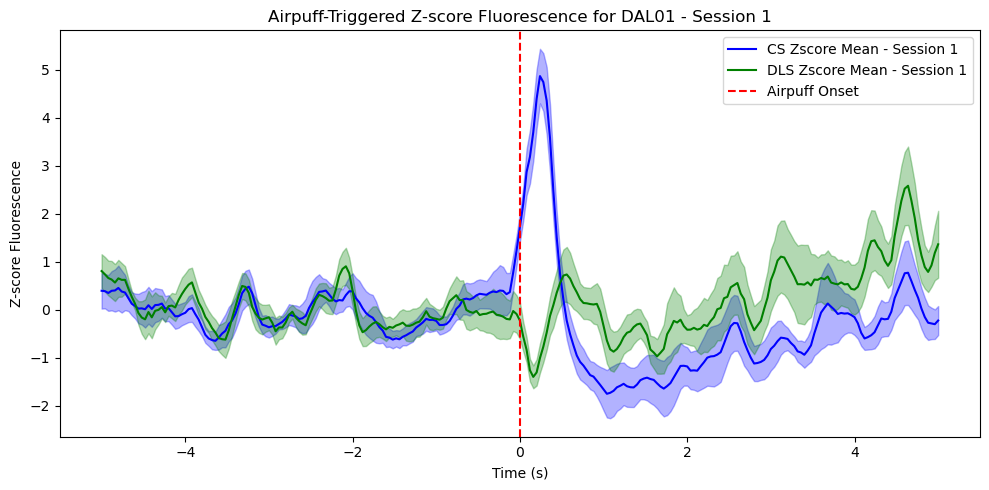

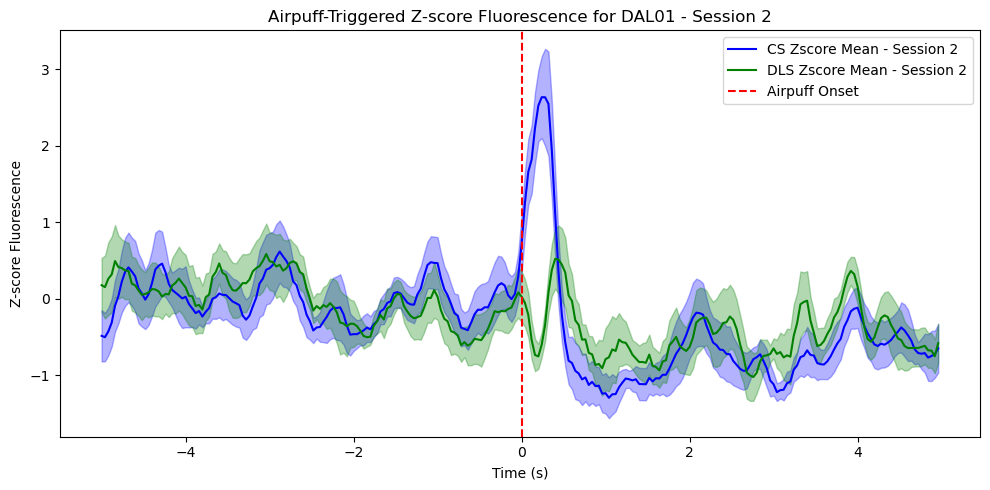

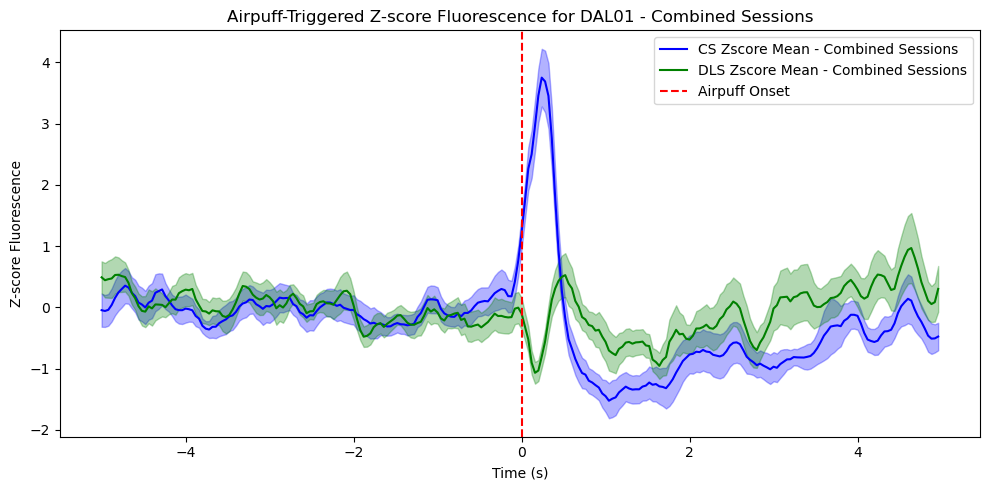

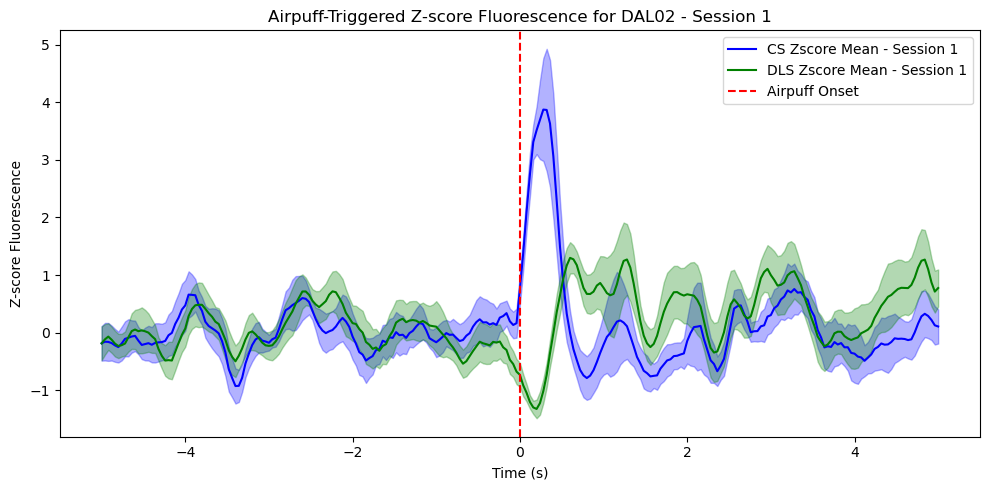

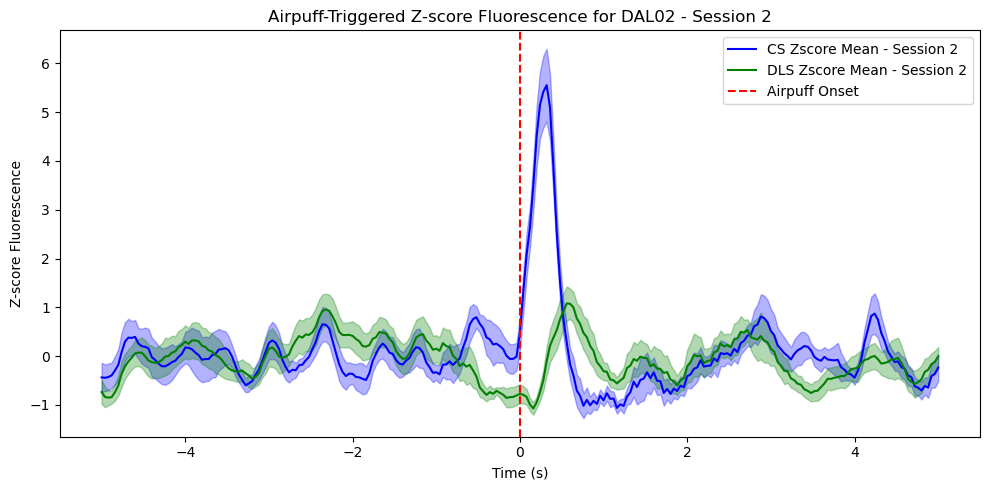

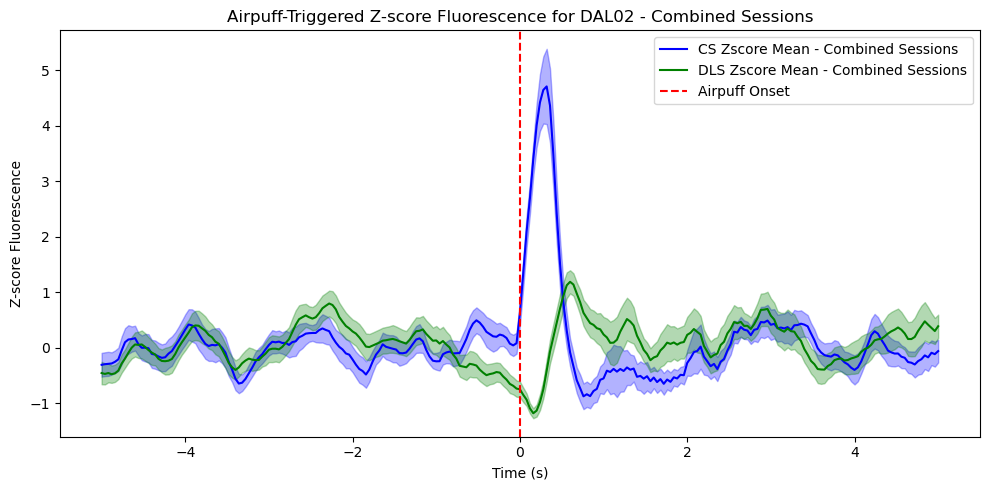

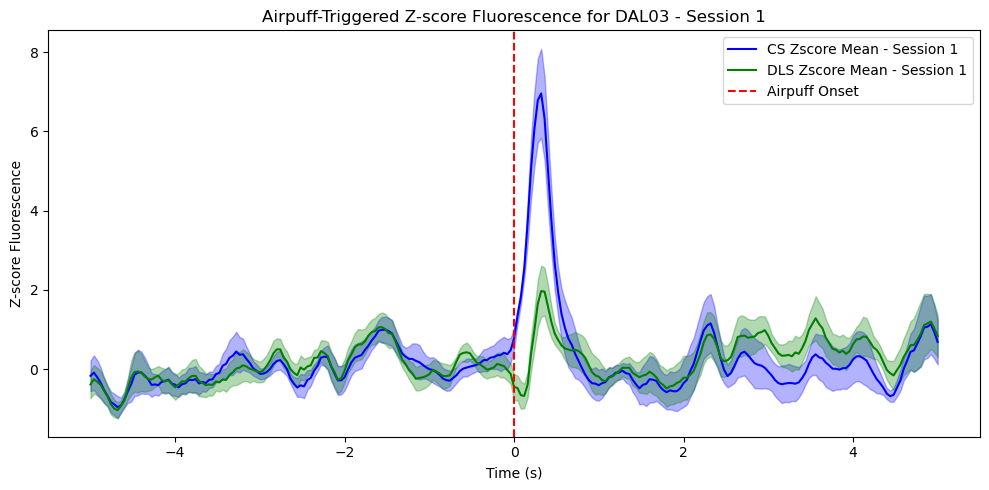

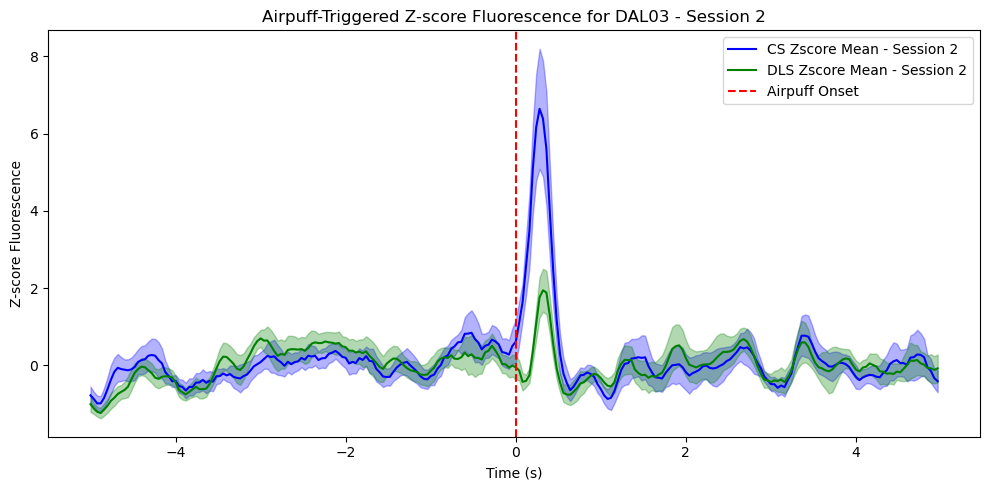

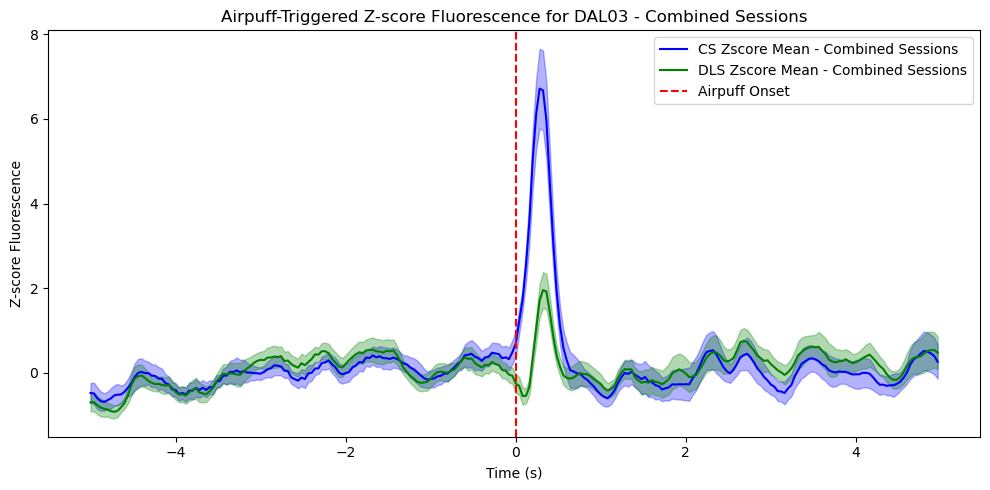

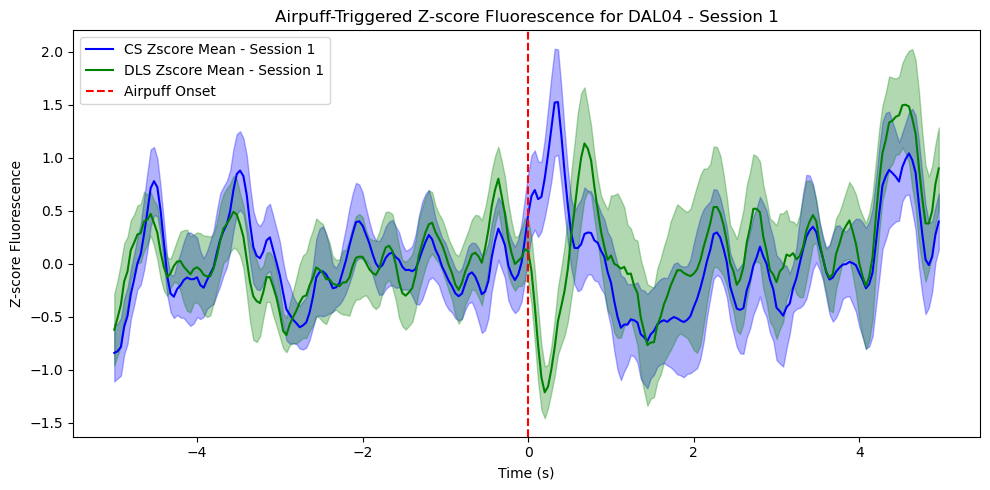

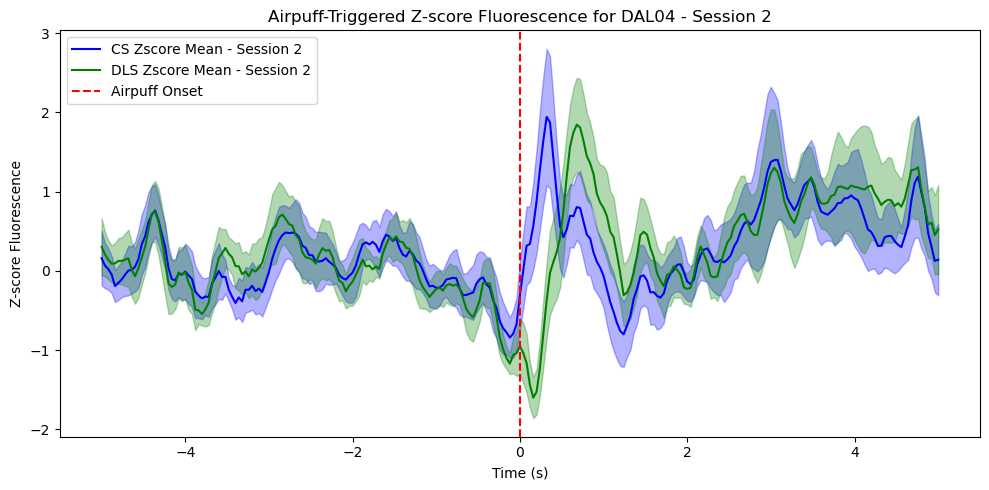

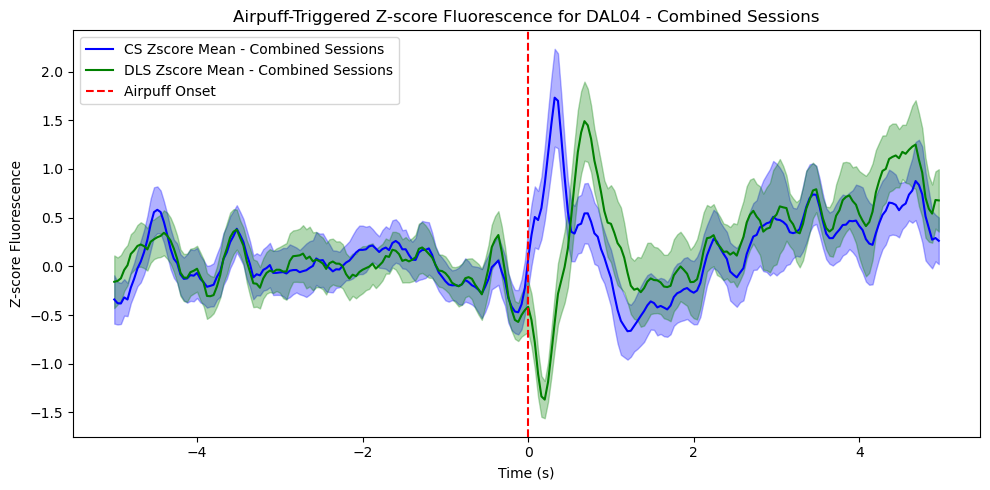

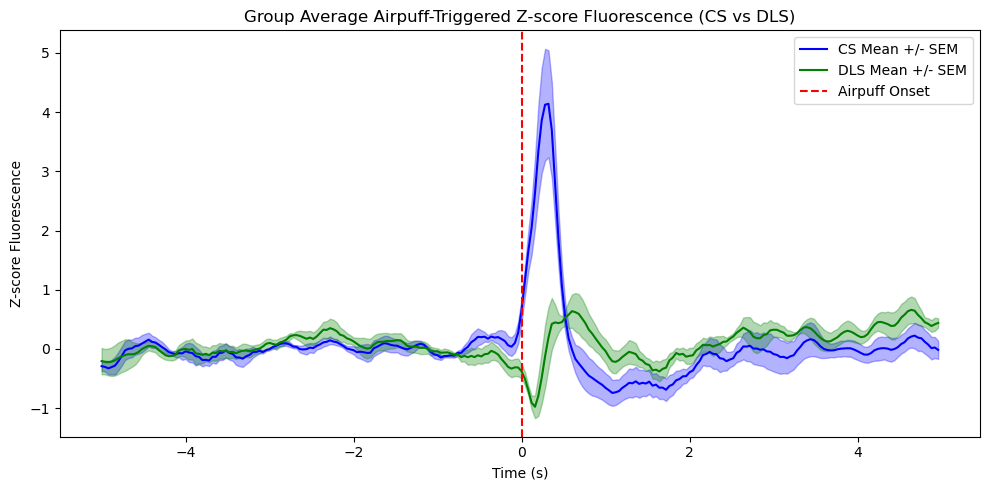

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mapping DAL mice to channels (CS vs DLS)
channel_mapping = {
    "DAL01": ("CS", "DLS"),  # Ch1 is CS, Ch2 is DLS for DAL01
    "DAL02": ("DLS", "CS"),  # Ch1 is DLS, Ch2 is CS for DAL02
    "DAL03": ("CS", "DLS"),  # Ch1 is CS, Ch2 is DLS for DAL03
    "DAL04": ("DLS", "CS")   # Ch1 is DLS, Ch2 is CS for DAL04
}

# Function to load and process fluorescence data, focusing on the first 9 Zscore columns
def load_and_process_fluorescence(file_path):
    data = pd.read_csv(file_path)
    time = data.iloc[:, 0].values / 1000  # Convert milliseconds to seconds
    zscore_columns = [col for col in data.columns if "Zscore" in col][:9]  # Select first 9 Zscore columns
    zscore_data = data[zscore_columns].values
    return time, zscore_data

# Function to plot session data for each mouse
def plot_session_data(time, cs_mean, dls_mean, cs_sem, dls_sem, session_label, mouse_id):
    plt.figure(figsize=(10, 5))

    # Plot CS Zscore
    plt.plot(time, cs_mean, color='blue', label=f'CS Zscore Mean - {session_label}')
    plt.fill_between(time, cs_mean - cs_sem, cs_mean + cs_sem, color='blue', alpha=0.3)

    # Plot DLS Zscore
    plt.plot(time, dls_mean, color='green', label=f'DLS Zscore Mean - {session_label}')
    plt.fill_between(time, dls_mean - dls_sem, dls_mean + dls_sem, color='green', alpha=0.3)

    # Formatting
    plt.axvline(x=0, color='red', linestyle='--', label='Airpuff Onset')
    plt.title(f'Airpuff-Triggered Z-score Fluorescence for {mouse_id} - {session_label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Z-score Fluorescence')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to calculate mean and SEM
def calculate_mean_sem(data):
    mean = np.mean(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(data.shape[1])
    return mean, sem

# Function to process sessions and calculate mean/SEM for a given mouse
def process_sessions(ch1_file, ch2_file, ch1_label, ch2_label, session_label, mouse_id):
    time, zscore_ch1 = load_and_process_fluorescence(ch1_file)
    _, zscore_ch2 = load_and_process_fluorescence(ch2_file)
    
    # Assign channels based on the mouse's configuration
    if ch1_label == "CS":
        cs_data = zscore_ch1
        dls_data = zscore_ch2
    else:
        cs_data = zscore_ch2
        dls_data = zscore_ch1
    
    # Calculate means and SEM
    cs_mean, cs_sem = calculate_mean_sem(cs_data)
    dls_mean, dls_sem = calculate_mean_sem(dls_data)

    # Plot the session data
    plot_session_data(time, cs_mean, dls_mean, cs_sem, dls_sem, session_label, mouse_id)
    
    return time, cs_data, dls_data

# Prepare to collect group-level data
all_cs_means = []
all_dls_means = []
time_common = None

# File paths for the datasets (Ch1 and Ch2 for each mouse)
datasets_session1 = {
    "DAL01": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right_Airpuff\2024_09_30-10_23_10\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right_Airpuff\2024_09_30-10_23_10\Ch2_Fluorescence_Trail.csv"),
    "DAL02": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_04_50\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_04_50\Ch2_Fluorescence_Trail.csv"),
    "DAL03": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_45_00\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_45_00\Ch2_Fluorescence_Trail.csv"),
    "DAL04": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right_Airpuff\2024_09_30-12_30_15\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right_Airpuff\2024_09_30-12_30_15\Ch2_Fluorescence_Trail.csv")
}

# File paths for the datasets (Ch1 and Ch2 for each mouse)
datasets_session2 = {
    "DAL01": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL01_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-10_57_23\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL01_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-10_57_23\Ch2_Fluorescence_Trail.csv"),
    "DAL02": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL02_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-11_42_17\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL02_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-11_42_17\Ch2_Fluorescence_Trail.csv"),
    "DAL03": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL03_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-12_25_38\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL03_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-12_25_38\Ch2_Fluorescence_Trail.csv"),
    "DAL04": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL04_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-13_10_23\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL04_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-13_10_23\Ch2_Fluorescence_Trail.csv")
}

# Process each dataset and assign channels based on the mapping
for mouse_id in datasets_session1.keys():
    ch1_file_s1, ch2_file_s1 = datasets_session1[mouse_id]
    ch1_file_s2, ch2_file_s2 = datasets_session2[mouse_id]
    ch1_label, ch2_label = channel_mapping[mouse_id]

    # Process session 1
    time_s1, cs_data_s1, dls_data_s1 = process_sessions(ch1_file_s1, ch2_file_s1, ch1_label, ch2_label, "Session 1", mouse_id)
    
    # Process session 2
    time_s2, cs_data_s2, dls_data_s2 = process_sessions(ch1_file_s2, ch2_file_s2, ch1_label, ch2_label, "Session 2", mouse_id)
    
    # Combine the first 9 trials from both sessions
    cs_combined = np.hstack((cs_data_s1[:, :9], cs_data_s2[:, :9]))
    dls_combined = np.hstack((dls_data_s1[:, :9], dls_data_s2[:, :9]))

    # Set the common time once
    if time_common is None:
        time_common = time_s1

    # Calculate means and SEM for the combined sessions
    cs_mean_combined, cs_sem_combined = calculate_mean_sem(cs_combined)
    dls_mean_combined, dls_sem_combined = calculate_mean_sem(dls_combined)

    # Plot combined session data
    plot_session_data(time_common, cs_mean_combined, dls_mean_combined, cs_sem_combined, dls_sem_combined, "Combined Sessions", mouse_id)

    # Store for group-level analysis
    all_cs_means.append(cs_mean_combined)
    all_dls_means.append(dls_mean_combined)

# Compute group-level averages and SEM for CS and DLS
group_mean_cs = np.mean(all_cs_means, axis=0)
group_mean_dls = np.mean(all_dls_means, axis=0)
group_sem_cs = np.std(all_cs_means, axis=0) / np.sqrt(len(all_cs_means))
group_sem_dls = np.std(all_dls_means, axis=0) / np.sqrt(len(all_dls_means))

# Plot the group-level averages
plt.figure(figsize=(10, 5))

# Plot group CS Zscore
plt.plot(time_common, group_mean_cs, color='blue', label='CS Mean +/- SEM')
plt.fill_between(time_common, group_mean_cs - group_sem_cs, group_mean_cs + group_sem_cs, color='blue', alpha=0.3)

# Plot group DLS Zscore
plt.plot(time_common, group_mean_dls, color='green', label='DLS Mean +/- SEM')
plt.fill_between(time_common, group_mean_dls - group_sem_dls, group_mean_dls + group_sem_dls, color='green', alpha=0.3)

# Formatting
plt.axvline(x=0, color='red', linestyle='--', label='Airpuff Onset')
plt.title('Group Average Airpuff-Triggered Z-score Fluorescence (CS vs DLS)')
plt.xlabel('Time (s)')
plt.ylabel('Z-score Fluorescence')
plt.legend()
plt.tight_layout()
plt.show()




Mouse DAL01:
  CS  Baseline AUC: 0.1403, CS  Post AUC: 1.0585
  DLS Baseline AUC: -0.1367, DLS Post AUC: -0.1121

Mouse DAL02:
  CS  Baseline AUC: 0.1694, CS  Post AUC: 1.5638
  DLS Baseline AUC: -0.3413, DLS Post AUC: -0.0291

Mouse DAL04:
  CS  Baseline AUC: -0.1490, CS  Post AUC: 0.5599
  DLS Baseline AUC: -0.1292, DLS Post AUC: -0.0854

Group-level AUCs:
  CS  Baseline: 0.0536 ± 0.1016, CS  Post: 1.0607 ± 0.2898
  DLS Baseline: -0.2024 ± 0.0695, DLS Post: -0.0755 ± 0.0245



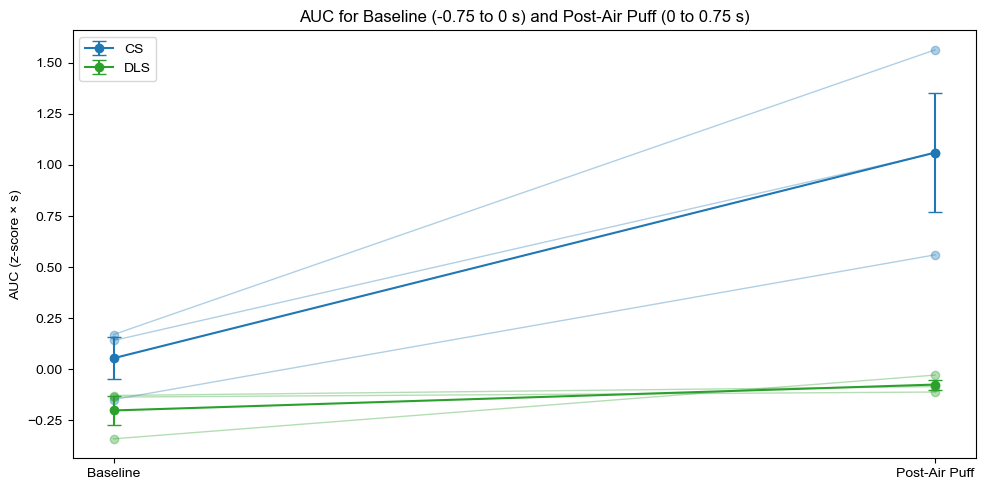

In [56]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# Config
# ======================
BASELINE_WINDOW = (-0.75, 0.0)   # seconds
POST_WINDOW     = (0.0, 0.75)    # seconds
MAX_TRIALS      = 9              # use first 9 Z-score trials

# Colors
CS_COLOR  = 'tab:blue'
DLS_COLOR = 'tab:green'

# Channel mapping: (label_on_Ch1, label_on_Ch2)
channel_mapping = {
    "DAL01": ("CS",  "DLS"),
    "DAL02": ("DLS", "CS"),
    "DAL03": ("CS",  "DLS"),
    "DAL04": ("DLS", "CS"),
}

# ======================
# Utility
# ======================
# NumPy ≥2.0 uses trapezoid; alias for compatibility
try:
    _trapz = np.trapezoid
except AttributeError:
    _trapz = np.trapz

def pick_zscore_columns(df, limit=MAX_TRIALS):
    """
    Return the first `limit` Z-score columns.
    Accepts 'Zscore' or 'Z-score' in the name.
    Sorts by trailing integer if present to ensure true order (1..N).
    """
    cand = [c for c in df.columns if ('Zscore' in c) or ('Z-score' in c)]
    if not cand:
        raise ValueError("No Z-score columns found (looked for 'Zscore' or 'Z-score').")

    def sort_key(c):
        m = re.search(r'(\d+)\s*$', c)
        return (0, int(m.group(1))) if m else (1, c)
    cand = sorted(cand, key=sort_key)
    return cand[:limit]

def load_time_and_zscores(csv_path, limit=MAX_TRIALS):
    """
    Load CSV where the first column is time in ms; return (time_in_s, Z[T, trials]).
    """
    df = pd.read_csv(csv_path)
    time = pd.to_numeric(df.iloc[:, 0], errors='coerce').values / 1000.0
    z_cols = pick_zscore_columns(df, limit=limit)
    Z = df[z_cols].apply(pd.to_numeric, errors='coerce').values
    return time, Z

def calculate_auc(time, y, t0, t1):
    """
    AUC of y(time) over [t0, t1] with trapezoidal integration.
    Drops NaNs inside window; returns NaN if <2 valid points.
    """
    mask = (time >= t0) & (time <= t1)
    if not np.any(mask):
        return np.nan
    t = time[mask]
    v = y[mask]
    finite = np.isfinite(t) & np.isfinite(v)
    if finite.sum() < 2:
        return np.nan
    return _trapz(v[finite], t[finite])

def mean_and_sem(arr):
    arr = np.asarray(arr, float)
    n = np.isfinite(arr).sum()
    mean = np.nanmean(arr)
    sem  = (np.nanstd(arr, ddof=1) / np.sqrt(n)) if n > 1 else np.nan
    return mean, sem

def region_mean_trace_for_session(label_ch1,   # e.g., "CS" or "DLS" on Ch1
                                  time_ch1, Z_ch1,
                                  time_ch2, Z_ch2,
                                  region_name): # "CS" or "DLS" we want
    """
    Given which label sits on channel 1 for this mouse in this session,
    return (time, mean_trace) for the requested region_name ("CS"/"DLS").
    """
    # Average across trials first
    m_ch1 = np.nanmean(Z_ch1, axis=1)
    m_ch2 = np.nanmean(Z_ch2, axis=1)

    # Determine which channel corresponds to the requested region
    if label_ch1 == region_name:
        # region sits on channel 1
        return time_ch1, m_ch1
    else:
        # region sits on channel 2
        return time_ch2, m_ch2

# ======================
# Data paths
# ======================
datasets_session1 = {
    "DAL01": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right_Airpuff\2024_09_30-10_23_10\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL01_Ch1Left_Ch2Right_Airpuff\2024_09_30-10_23_10\Ch2_Fluorescence_Trail.csv"),
    "DAL02": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_04_50\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL02_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_04_50\Ch2_Fluorescence_Trail.csv"),
    "DAL03": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_45_00\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL03_Ch1Left_Ch2Right_Airpuff\2024_09_30-11_45_00\Ch2_Fluorescence_Trail.csv"),
    "DAL04": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right_Airpuff\2024_09_30-12_30_15\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20240930\DAL04_Ch1Left_Ch2Right_Airpuff\2024_09_30-12_30_15\Ch2_Fluorescence_Trail.csv"),
}
datasets_session2 = {
    "DAL01": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL01_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-10_57_23\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL01_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-10_57_23\Ch2_Fluorescence_Trail.csv"),
    "DAL02": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL02_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-11_42_17\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL02_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-11_42_17\Ch2_Fluorescence_Trail.csv"),
    "DAL03": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL03_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-12_25_38\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL03_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-12_25_38\Ch2_Fluorescence_Trail.csv"),
    "DAL04": (r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL04_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-13_10_23\Ch1_Fluorescence_Trail.csv",
              r"K:\Fiber_Photometry\Data\cjDAE-GCaMP6f\20241004\DAL04_LeftCh1_RightCh2_10X-AirPuff\2024_10_04-13_10_23\Ch2_Fluorescence_Trail.csv"),
}

# ======================
# Analysis
# ======================
cs_baseline_auc = []
cs_post_auc     = []
dls_baseline_auc = []
dls_post_auc     = []

for mouse_id in datasets_session1:
    ch1_file_s1, ch2_file_s1 = datasets_session1[mouse_id]
    ch1_file_s2, ch2_file_s2 = datasets_session2[mouse_id]
    label_ch1, label_ch2     = channel_mapping[mouse_id]  # which label sits on Ch1/Ch2

    # Load session 1
    t1_ch1, Z1_ch1 = load_time_and_zscores(ch1_file_s1, limit=MAX_TRIALS)
    t1_ch2, Z1_ch2 = load_time_and_zscores(ch2_file_s1, limit=MAX_TRIALS)
    # Load session 2
    t2_ch1, Z2_ch1 = load_time_and_zscores(ch1_file_s2, limit=MAX_TRIALS)
    t2_ch2, Z2_ch2 = load_time_and_zscores(ch2_file_s2, limit=MAX_TRIALS)

    # Harmonize trial count across all 4 arrays for this mouse
    n_trials = min(Z1_ch1.shape[1], Z1_ch2.shape[1], Z2_ch1.shape[1], Z2_ch2.shape[1], MAX_TRIALS)
    if n_trials < MAX_TRIALS:
        print(f"[{mouse_id}] Using {n_trials} trials (limited by available data).")
    Z1_ch1, Z1_ch2 = Z1_ch1[:, :n_trials], Z1_ch2[:, :n_trials]
    Z2_ch1, Z2_ch2 = Z2_ch1[:, :n_trials], Z2_ch2[:, :n_trials]

    # --- Session 1: get region traces on the correct channels for this mouse ---
    t1_cs,  m1_cs  = region_mean_trace_for_session(label_ch1, t1_ch1, Z1_ch1, t1_ch2, Z1_ch2, "CS")
    t1_dls, m1_dls = region_mean_trace_for_session(label_ch1, t1_ch1, Z1_ch1, t1_ch2, Z1_ch2, "DLS")

    # --- Session 2 ---
    t2_cs,  m2_cs  = region_mean_trace_for_session(label_ch1, t2_ch1, Z2_ch1, t2_ch2, Z2_ch2, "CS")
    t2_dls, m2_dls = region_mean_trace_for_session(label_ch1, t2_ch1, Z2_ch1, t2_ch2, Z2_ch2, "DLS")

    # AUCs per session (each on its own timebase)
    cs_base_s1 = calculate_auc(t1_cs,  m1_cs,  *BASELINE_WINDOW)
    cs_post_s1 = calculate_auc(t1_cs,  m1_cs,  *POST_WINDOW)
    cs_base_s2 = calculate_auc(t2_cs,  m2_cs,  *BASELINE_WINDOW)
    cs_post_s2 = calculate_auc(t2_cs,  m2_cs,  *POST_WINDOW)

    dls_base_s1 = calculate_auc(t1_dls, m1_dls, *BASELINE_WINDOW)
    dls_post_s1 = calculate_auc(t1_dls, m1_dls, *POST_WINDOW)
    dls_base_s2 = calculate_auc(t2_dls, m2_dls, *BASELINE_WINDOW)
    dls_post_s2 = calculate_auc(t2_dls, m2_dls, *POST_WINDOW)

    # Per-mouse values = mean across sessions
    cs_base  = np.nanmean([cs_base_s1,  cs_base_s2])
    cs_post  = np.nanmean([cs_post_s1,  cs_post_s2])
    dls_base = np.nanmean([dls_base_s1, dls_base_s2])
    dls_post = np.nanmean([dls_post_s1, dls_post_s2])

    cs_baseline_auc.append(cs_base)
    cs_post_auc.append(cs_post)
    dls_baseline_auc.append(dls_base)
    dls_post_auc.append(dls_post)

    print(f"Mouse {mouse_id}:")
    print(f"  CS  Baseline AUC: {cs_base:.4f}, CS  Post AUC: {cs_post:.4f}")
    print(f"  DLS Baseline AUC: {dls_base:.4f}, DLS Post AUC: {dls_post:.4f}\n")

# ======================
# Group stats
# ======================
mean_cs_base,  sem_cs_base  = mean_and_sem(cs_baseline_auc)
mean_cs_post,  sem_cs_post  = mean_and_sem(cs_post_auc)
mean_dls_base, sem_dls_base = mean_and_sem(dls_baseline_auc)
mean_dls_post, sem_dls_post = mean_and_sem(dls_post_auc)

print("Group-level AUCs:")
print(f"  CS  Baseline: {mean_cs_base:.4f} ± {sem_cs_base:.4f}, CS  Post: {mean_cs_post:.4f} ± {sem_cs_post:.4f}")
print(f"  DLS Baseline: {mean_dls_base:.4f} ± {sem_dls_base:.4f}, DLS Post: {mean_dls_post:.4f} ± {sem_dls_post:.4f}\n")

# ======================
# Plot
# ======================
plt.figure(figsize=(10, 5))

# CS mean ± SEM (blue)
plt.errorbar(['Baseline', 'Post-Air Puff'],
             [mean_cs_base, mean_cs_post],
             yerr=[sem_cs_base, sem_cs_post],
             fmt='o-', color=CS_COLOR, label='CS', capsize=5, zorder=3)
# Paired CS lines
for b, p in zip(cs_baseline_auc, cs_post_auc):
    plt.plot(['Baseline', 'Post-Air Puff'], [b, p],
             'o-', color=CS_COLOR, alpha=0.35, linewidth=1, zorder=2)

# DLS mean ± SEM (green)
plt.errorbar(['Baseline', 'Post-Air Puff'],
             [mean_dls_base, mean_dls_post],
             yerr=[sem_dls_base, sem_dls_post],
             fmt='o-', color=DLS_COLOR, label='DLS', capsize=5, zorder=3)
# Paired DLS lines
for b, p in zip(dls_baseline_auc, dls_post_auc):
    plt.plot(['Baseline', 'Post-Air Puff'], [b, p],
             'o-', color=DLS_COLOR, alpha=0.35, linewidth=1, zorder=2)

plt.title('AUC for Baseline (-0.75 to 0 s) and Post-Air Puff (0 to 0.75 s)')
plt.ylabel('AUC (z-score × s)')
plt.legend()
plt.tight_layout()
plt.show()


[CS] shape=(72, 251)  min=-4.644  max=15.843  %zeros=0.0%
[DLS] shape=(72, 251)  min=-4.639  max=8.150  %zeros=0.0%


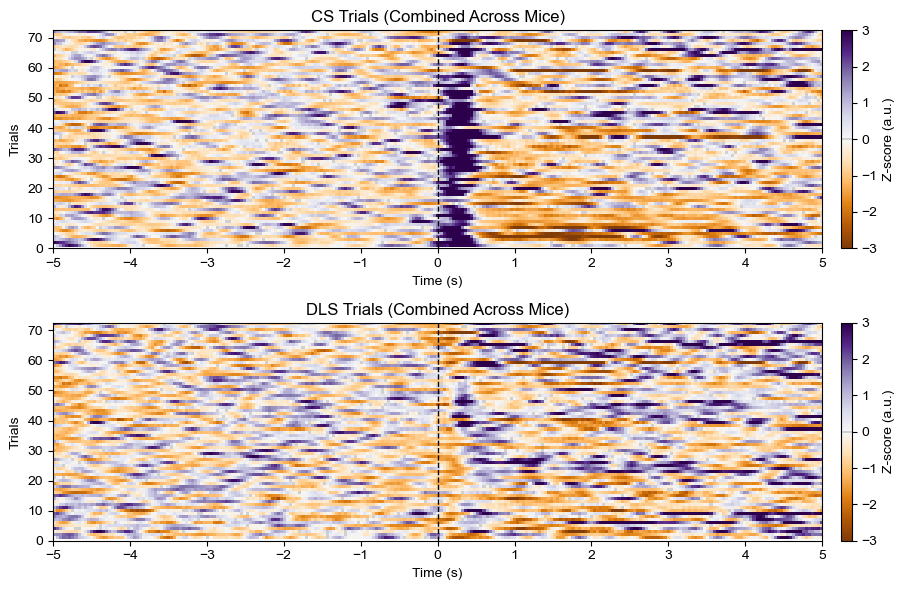

Saved: C:\Users\KianCaplan\Downloads\CS_DLS_Heatmaps.pdf


In [63]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# -------------------- Export directory (Downloads) --------------------
EXPORT_DIR = Path.home() / "Downloads"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Illustrator-friendly fonts
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

# ---------- Color-blind–safe diverging cmap with non-white midpoint ----------
def puor_midgray(mid_hex="#CFCFCF"):
    base = plt.get_cmap("PuOr", 256)
    colors = base(np.linspace(0, 1, 256))
    # set the exact center (index 128) to a light gray so zeros aren't “invisible”
    colors[127] = mpl.colors.to_rgba(mid_hex)
    colors[128] = mpl.colors.to_rgba(mid_hex)
    return LinearSegmentedColormap.from_list("PuOr_midgray", colors)

CB_MAP = puor_midgray("#D0D0D0")  # slightly gray center

# -------------------- IO & preprocessing --------------------
def load_and_process_fluorescence(file_path):
    df = pd.read_csv(file_path)
    time = df.iloc[:, 0].values / 1000.0  # ms → s

    # be robust to header variants
    cols = [c for c in df.columns if "zscore" in c.lower()]
    if len(cols) == 0:
        raise ValueError(f"No Zscore-like columns found in {file_path}. "
                         f"Columns were: {list(df.columns)[:10]} ...")
    cols = cols[:9]  # first 9 trials
    z = df[cols].to_numpy()
    return time, z

def handle_missing_data(data):
    return np.nan_to_num(data, nan=0.0)

def diag(name, arr):
    a = np.asarray(arr)
    print(f"[{name}] shape={a.shape}  min={np.nanmin(a):.3f}  max={np.nanmax(a):.3f}  "
          f"%zeros={(a==0).mean()*100:.1f}%")

# -------------------- Plotting --------------------
def plot_heatmap(data_trials_by_time, time, title, ax, vmin=-3, vmax=3, cmap=CB_MAP):
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    ax.set_facecolor('none')  # transparent axes
    im = ax.imshow(
        data_trials_by_time,
        aspect='auto',
        interpolation='nearest',
        extent=[time[0], time[-1], 0.5, data_trials_by_time.shape[0] + 0.5],
        cmap=cmap,
        norm=norm,
        origin='lower'
    )
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_xticks(np.arange(np.floor(time[0]), np.ceil(time[-1]) + 1, 1))
    ax.set_yticks(np.arange(0, data_trials_by_time.shape[0] + 1, 10))
    ax.set_ylabel('Trials'); ax.set_xlabel('Time (s)'); ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax, pad=0.02); cbar.set_label('Z-score (a.u.)')
    return im

# -------------------- Channel mapping --------------------
channel_mapping = {
    "DAL01": ("CS", "DLS"),
    "DAL02": ("DLS", "CS"),
    "DAL03": ("CS", "DLS"),
    "DAL04": ("DLS", "CS"),
}

# -------------------- File paths (use forward slashes) --------------------
datasets_session1 = {
    "DAL01": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL01_Ch1Left_Ch2Right_Airpuff/2024_09_30-10_23_10/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL01_Ch1Left_Ch2Right_Airpuff/2024_09_30-10_23_10/Ch2_Fluorescence_Trail.csv"),
    "DAL02": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL02_Ch1Left_Ch2Right_Airpuff/2024_09_30-11_04_50/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL02_Ch1Left_Ch2Right_Airpuff/2024_09_30-11_04_50/Ch2_Fluorescence_Trail.csv"),
    "DAL03": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL03_Ch1Left_Ch2Right_Airpuff/2024_09_30-11_45_00/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL03_Ch1Left_Ch2Right_Airpuff/2024_09_30-11_45_00/Ch2_Fluorescence_Trail.csv"),
    "DAL04": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL04_Ch1Left_Ch2Right_Airpuff/2024_09_30-12_30_15/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20240930/DAL04_Ch1Left_Ch2Right_Airpuff/2024_09_30-12_30_15/Ch2_Fluorescence_Trail.csv"),
}

datasets_session2 = {
    "DAL01": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL01_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-10_57_23/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL01_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-10_57_23/Ch2_Fluorescence_Trail.csv"),
    "DAL02": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL02_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-11_42_17/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL02_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-11_42_17/Ch2_Fluorescence_Trail.csv"),
    "DAL03": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL03_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-12_25_38/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL03_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-12_25_38/Ch2_Fluorescence_Trail.csv"),
    "DAL04": ("K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL04_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-13_10_23/Ch1_Fluorescence_Trail.csv",
              "K:/Fiber_Photometry/Data/cjDAE-GCaMP6f/20241004/DAL04_LeftCh1_RightCh2_10X-AirPuff/2024_10_04-13_10_23/Ch2_Fluorescence_Trail.csv"),
}

# -------------------- Combine & plot --------------------
def process_sessions(ch1_file, ch2_file, ch1_label, ch2_label):
    time, z1 = load_and_process_fluorescence(ch1_file)
    _,   z2 = load_and_process_fluorescence(ch2_file)
    z1 = handle_missing_data(z1)
    z2 = handle_missing_data(z2)
    return (time, z1, z2) if ch1_label == "CS" else (time, z2, z1)

all_cs, all_dls, time_common = [], [], None
for mouse_id in datasets_session1:
    ch1_s1, ch2_s1 = datasets_session1[mouse_id]
    ch1_s2, ch2_s2 = datasets_session2[mouse_id]
    ch1_label, _ = channel_mapping[mouse_id]

    t1, cs1, dls1 = process_sessions(ch1_s1, ch2_s1, ch1_label, None)
    t2, cs2, dls2 = process_sessions(ch1_s2, ch2_s2, ch1_label, None)

    if time_common is None:
        time_common = t1

    cs = np.hstack((cs1[:, :9], cs2[:, :9]))
    dls = np.hstack((dls1[:, :9], dls2[:, :9]))
    all_cs.append(cs); all_dls.append(dls)

# Trials x time
CS = np.concatenate(all_cs, axis=1).T
DLS = np.concatenate(all_dls, axis=1).T

diag("CS", CS); diag("DLS", DLS)

fig = plt.figure(figsize=(10, 6))
fig.patch.set_alpha(0.0)  # transparent

ax1 = plt.subplot(2,1,1)
plot_heatmap(CS,  time_common, "CS Trials (Combined Across Mice)", ax1, vmin=-3, vmax=3, cmap=CB_MAP)
ax2 = plt.subplot(2,1,2)
plot_heatmap(DLS, time_common, "DLS Trials (Combined Across Mice)", ax2, vmin=-3, vmax=3, cmap=CB_MAP)

plt.tight_layout()
out_pdf = EXPORT_DIR / "CS_DLS_Heatmaps.pdf"
plt.savefig(out_pdf, dpi=300, transparent=True, bbox_inches='tight')
plt.show()
print(f"Saved: {out_pdf}")
